# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [324]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [325]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [326]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [327]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [328]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')

In [329]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


Let's look at each variable's datatype:

In [330]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        69999 no

Let's also summarize the features using the df.describe method:

In [331]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [332]:
data['circle_id'].unique()

array([109])

In [333]:
X = data.drop(['circle_id'], axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 22), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 22), (14000, 22), (55999,), (14000,))

In [335]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
47305,429,35,606,64.24,6.39,521.51,202.31,6.39,321.73,NaN,...,NaN,21.91,182.42,0.0,0.11,239.36,0.00,94.63,256.40,442
38674,0,416,476,0.00,696.94,949.89,NaN,200.98,302.79,NaN,...,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.00,1157
5339,230,135,225,35.96,46.91,51.49,24.43,37.23,45.53,13.79,...,0.0,0.04,0.00,701.6,273.25,505.66,2.93,3.55,10.26,1040
43390,30,110,161,0.00,234.13,214.54,3.86,136.28,96.18,NaN,...,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.00,440
16217,335,300,312,254.83,205.93,373.59,219.04,151.26,303.03,NaN,...,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.00,573


# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

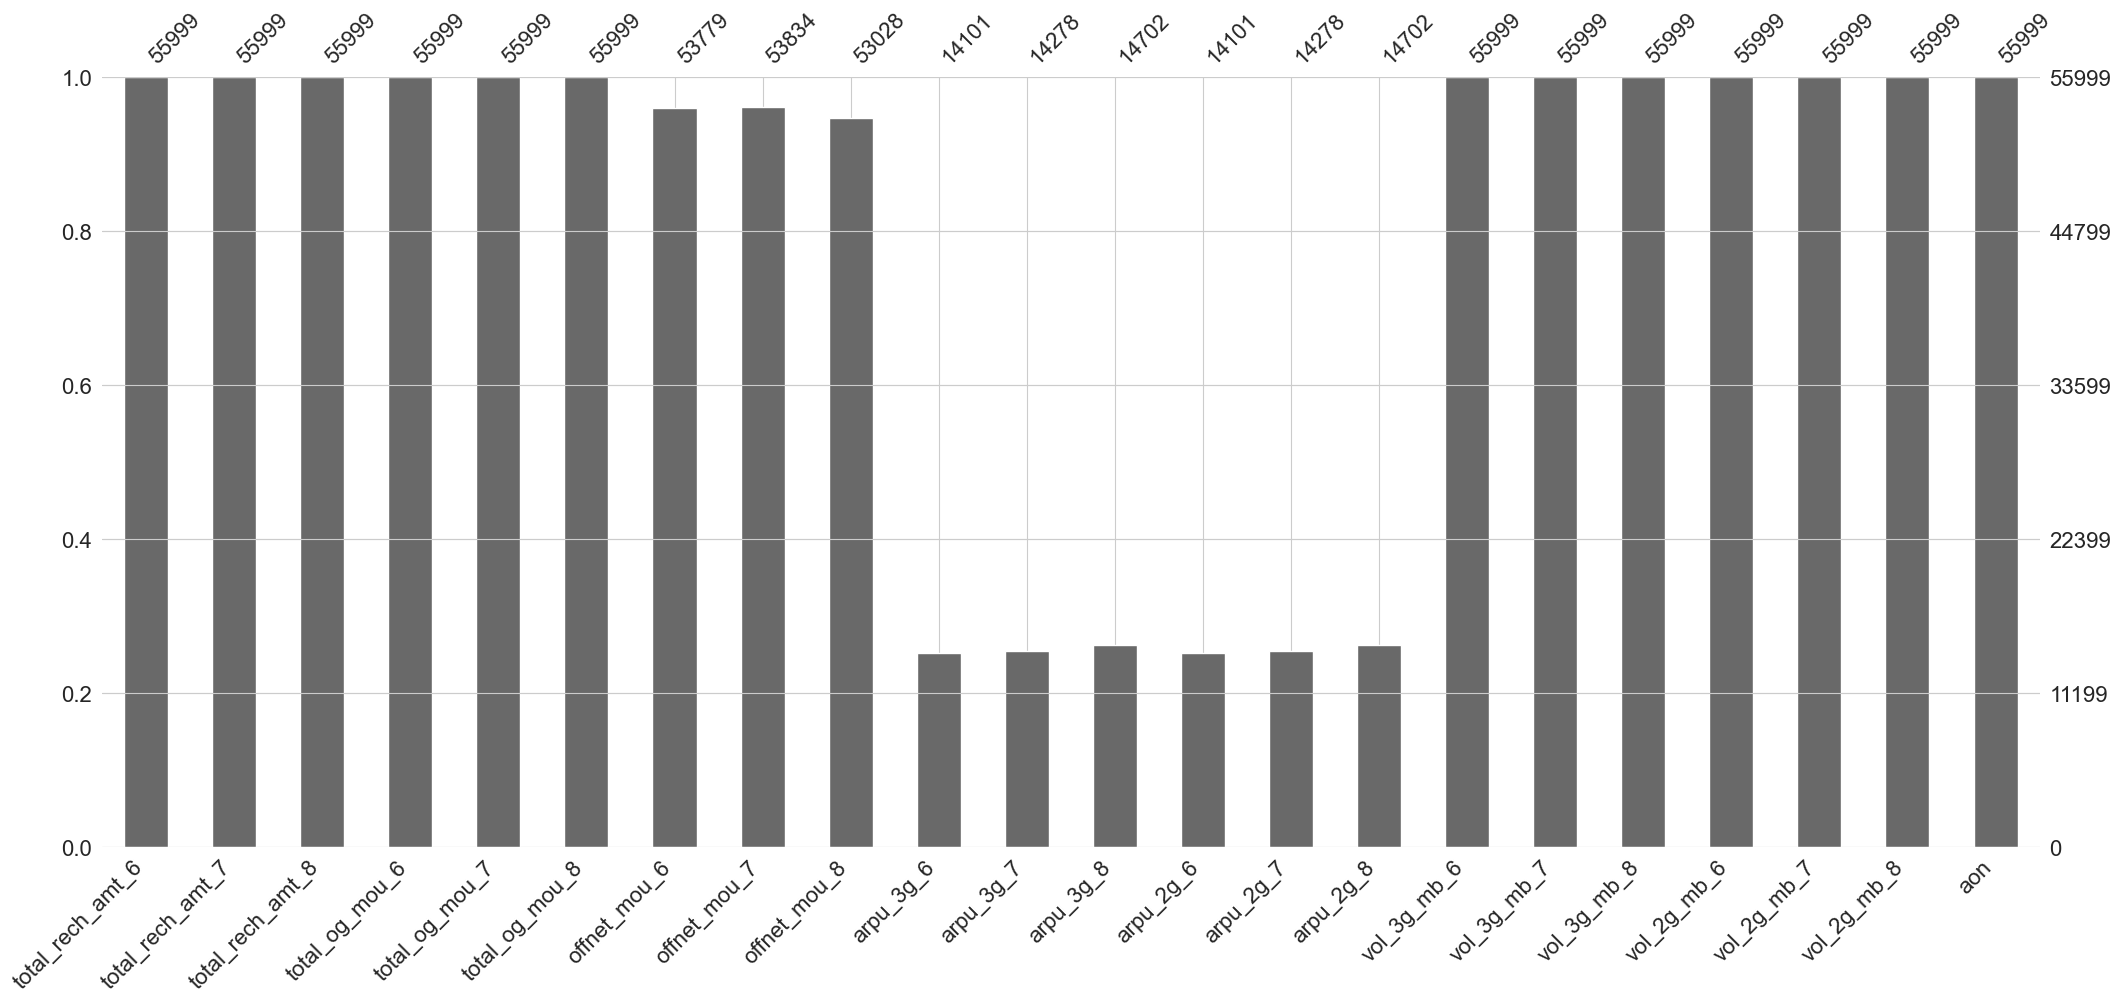

In [336]:
msno.bar(X_train)

<Axes: >

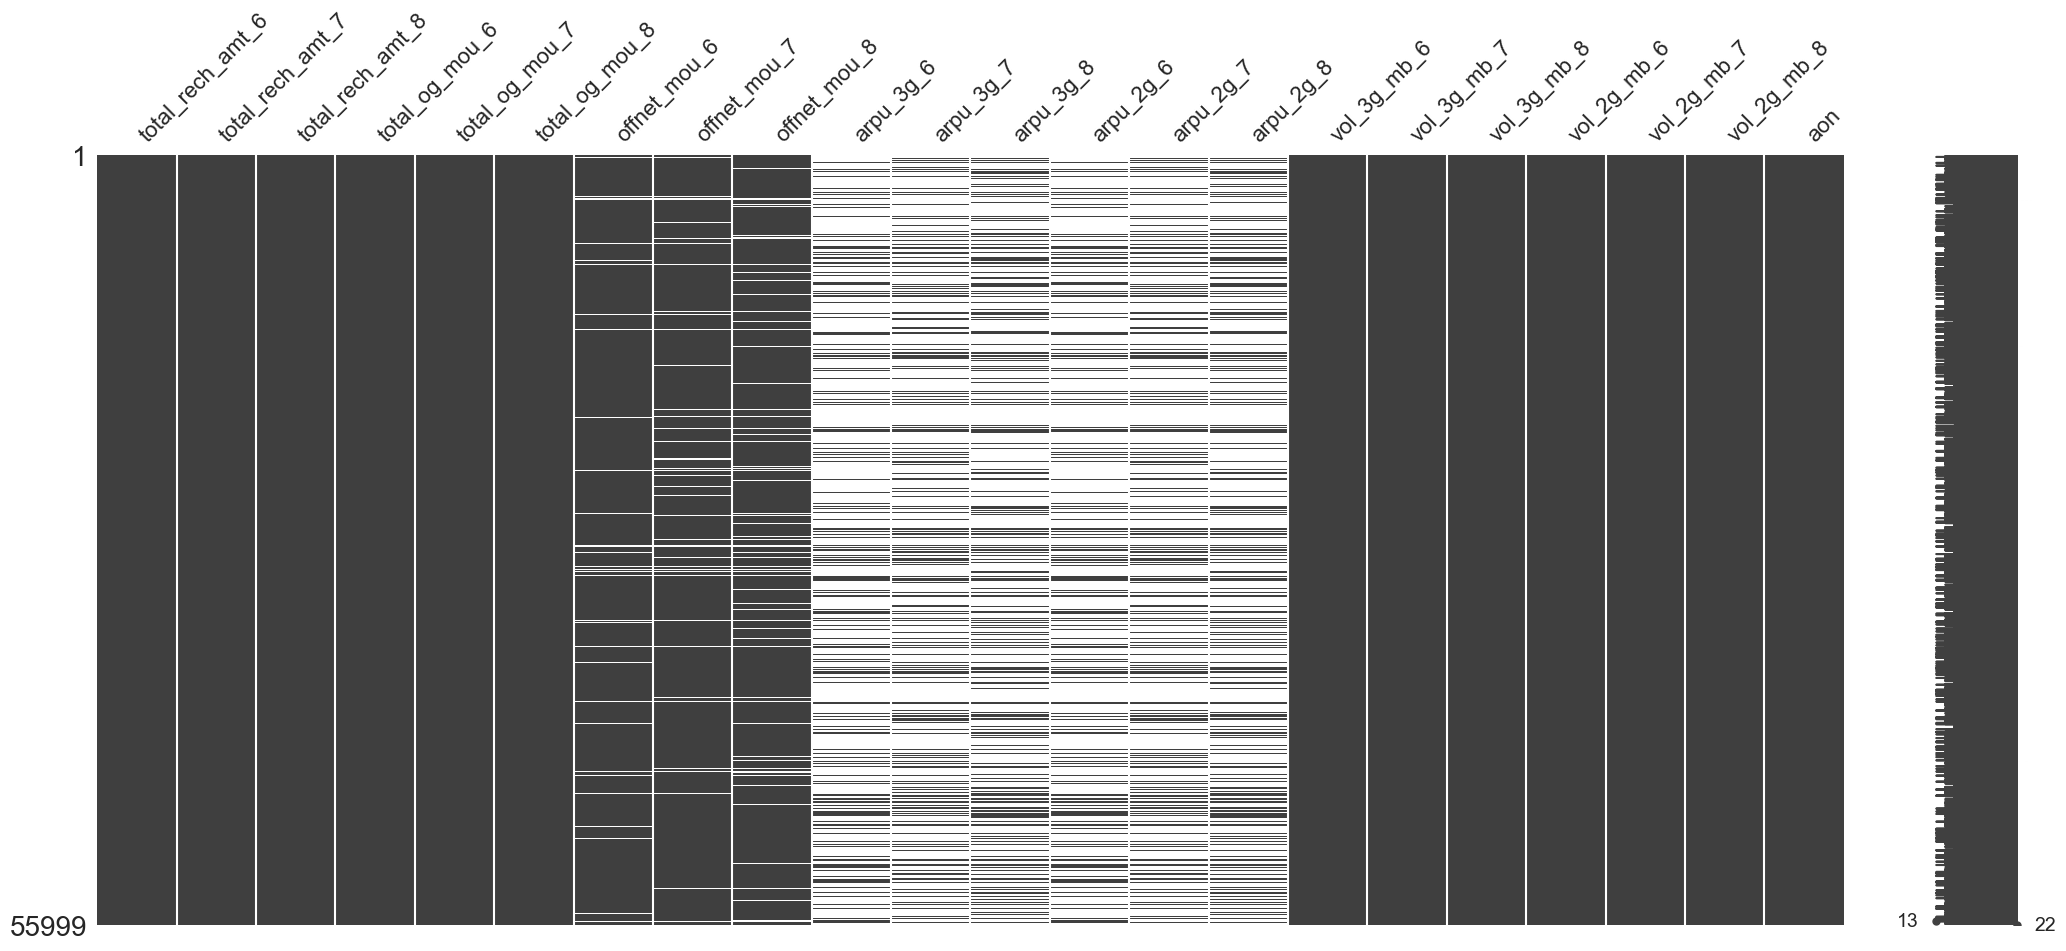

In [337]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [338]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
total_og_mou_6       0.000000
total_og_mou_7       0.000000
total_og_mou_8       0.000000
offnet_mou_6         3.964357
offnet_mou_7         3.866140
offnet_mou_8         5.305452
arpu_3g_6           74.819193
arpu_3g_7           74.503116
arpu_3g_8           73.745960
arpu_2g_6           74.819193
arpu_2g_7           74.503116
arpu_2g_8           73.745960
vol_3g_mb_6          0.000000
vol_3g_mb_7          0.000000
vol_3g_mb_8          0.000000
vol_2g_mb_6          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_8          0.000000
aon                  0.000000
dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [339]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [340]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 16)

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [341]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [342]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

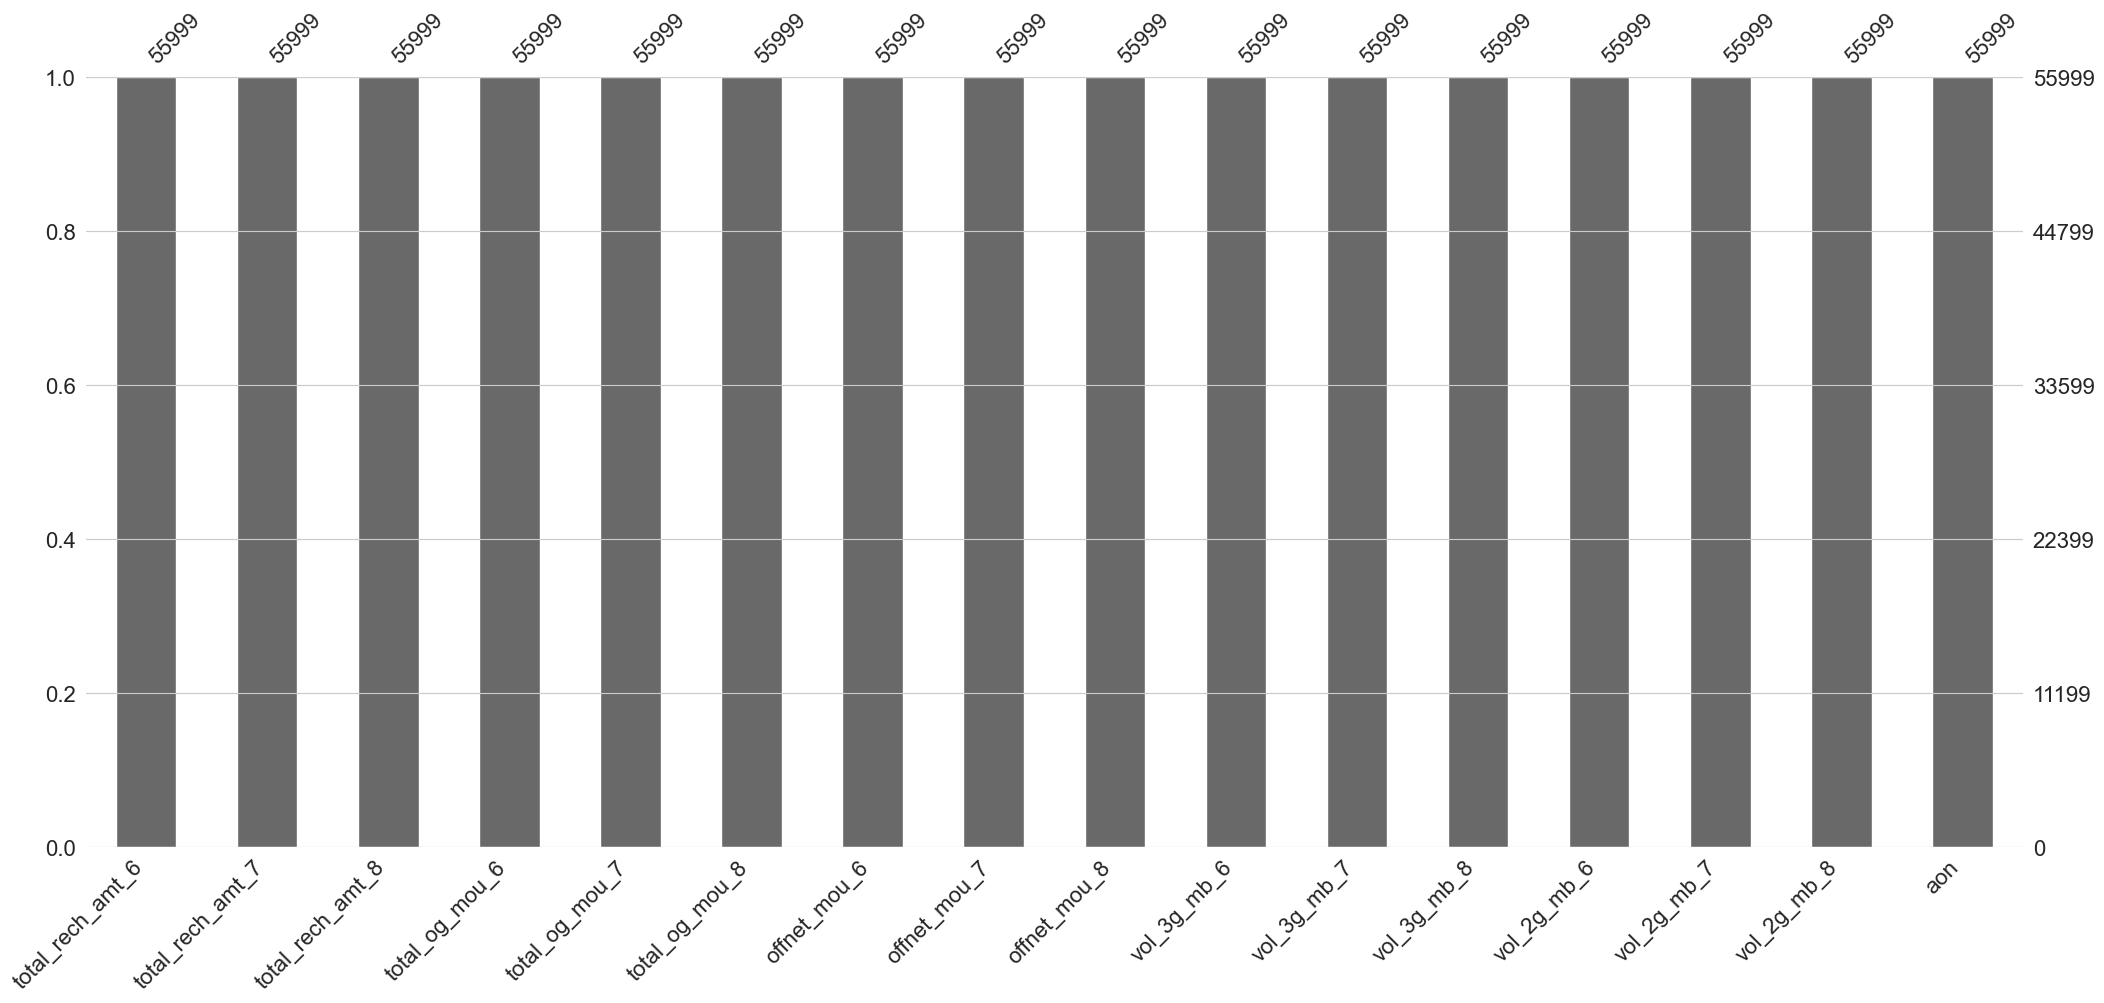

In [343]:
msno.bar(X_train_filtered)

In [344]:
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,327.869694,321.400936,322.594832,306.440048,310.079249,304.038773,191.265261,189.660842,186.320678,122.027026,127.523751,134.092778,52.470871,51.563960,50.332913,1222.629154
std,385.881086,384.328426,395.412767,467.440561,479.433501,479.287383,314.671760,319.600368,320.847422,561.696085,551.047976,565.549678,216.499153,213.909635,214.732747,953.143522
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,110.000000,100.000000,91.000000,44.960000,43.080000,39.270000,28.780000,26.870000,24.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.500000
50%,229.000000,220.000000,224.000000,145.410000,141.680000,138.640000,89.880000,85.790000,83.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,873.000000
75%,438.000000,429.000000,434.000000,372.790000,376.995000,369.835000,224.370000,218.000000,215.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816.000000
max,17840.000000,19204.000000,20405.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4299.000000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

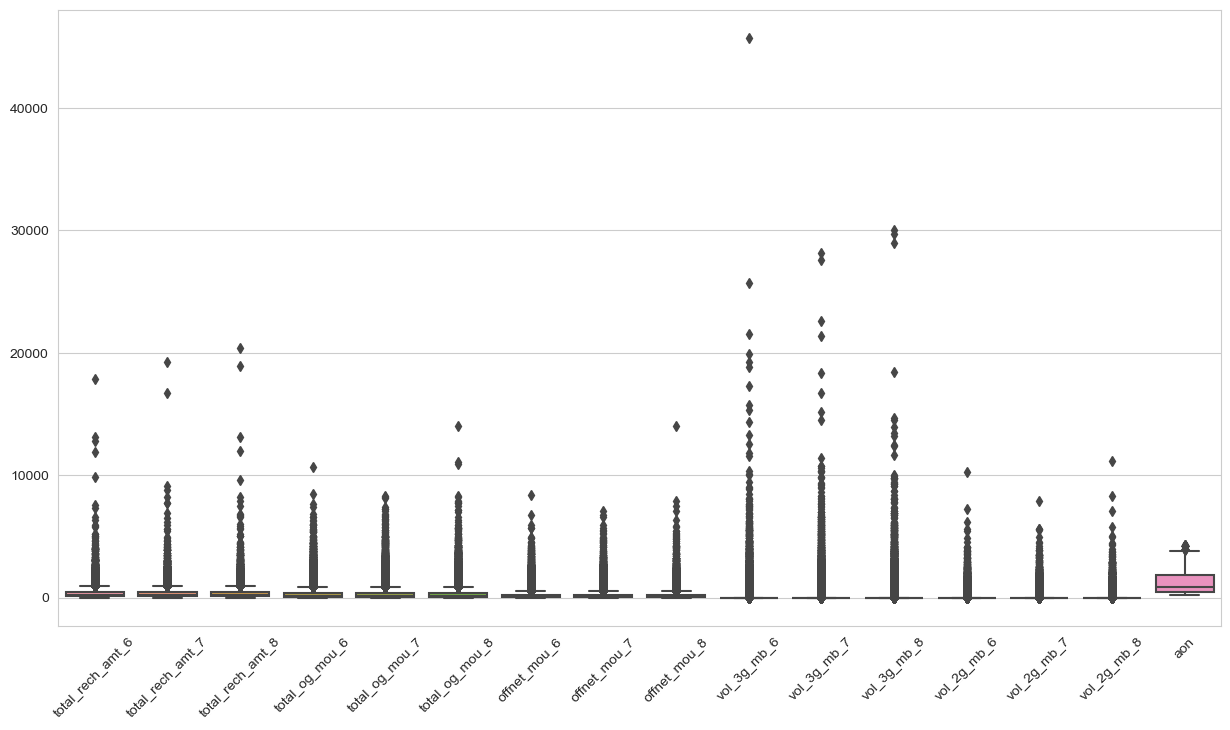

In [345]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [346]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

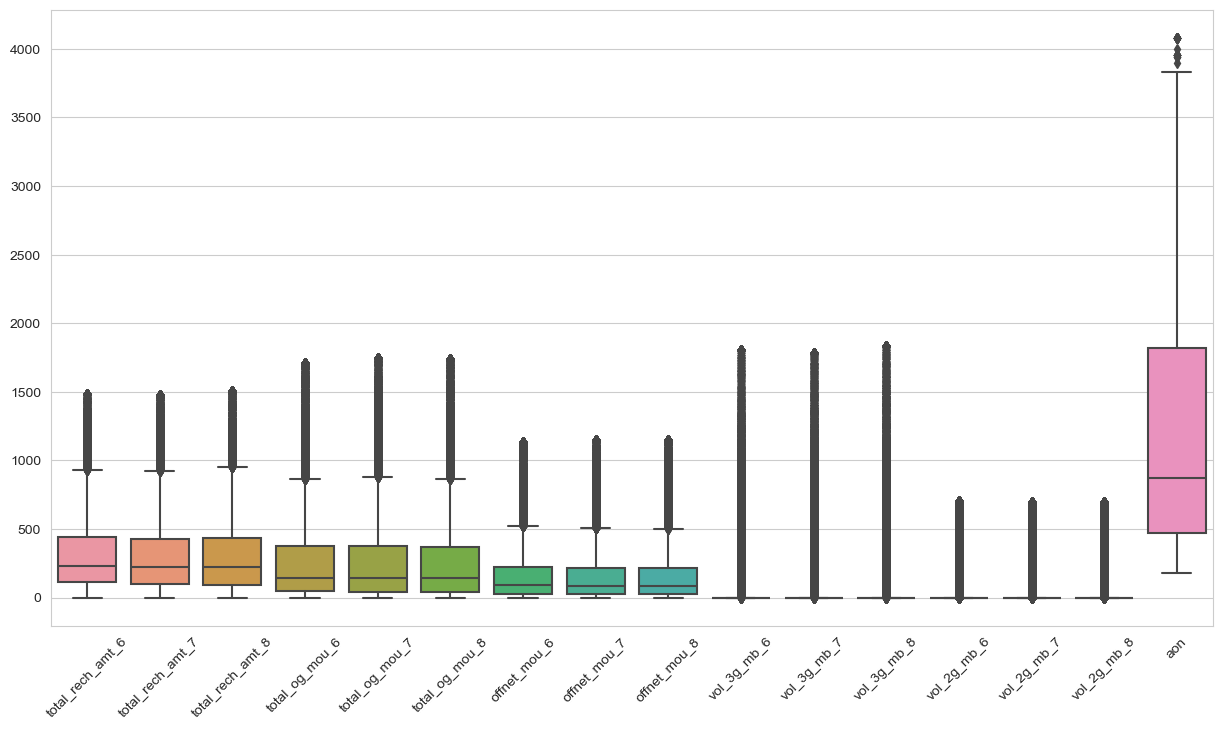

In [347]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [348]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

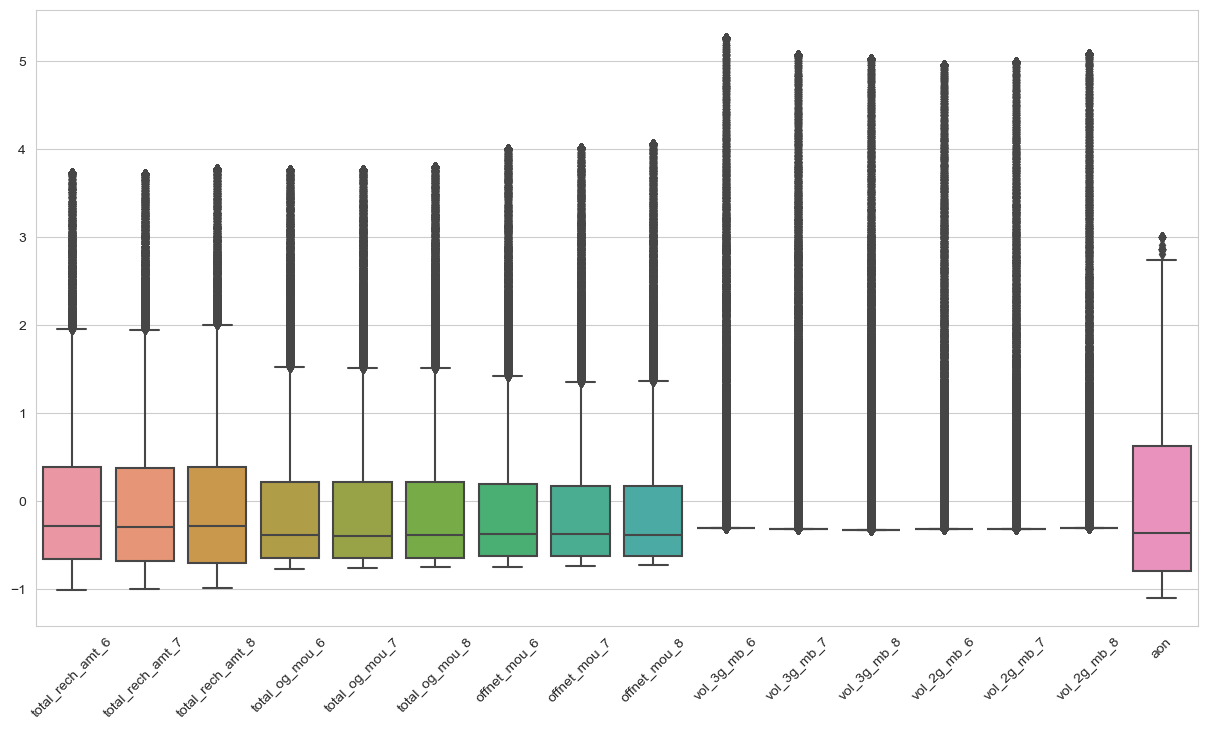

In [349]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

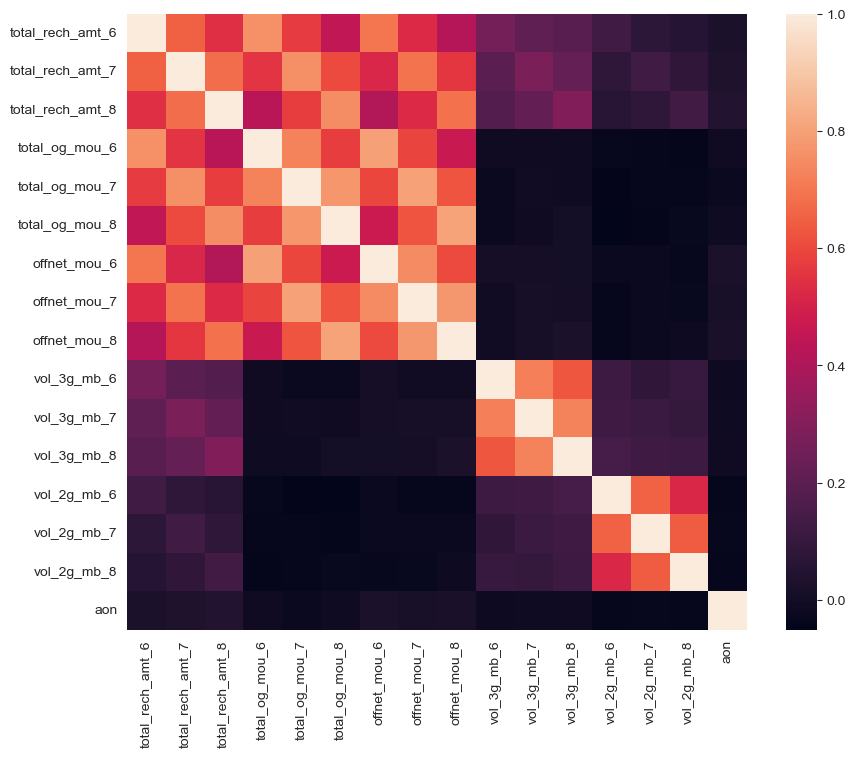

In [350]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

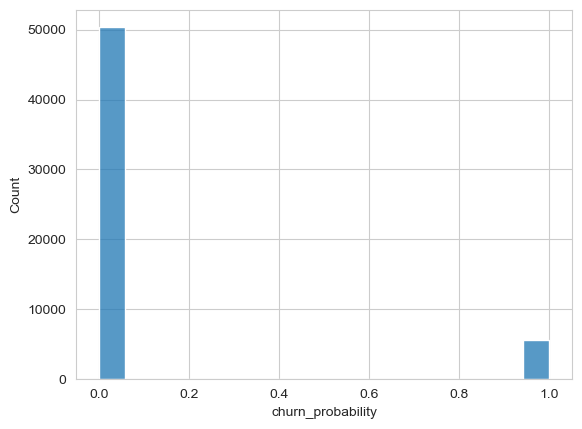

In [351]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [352]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [353]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 16 artists>

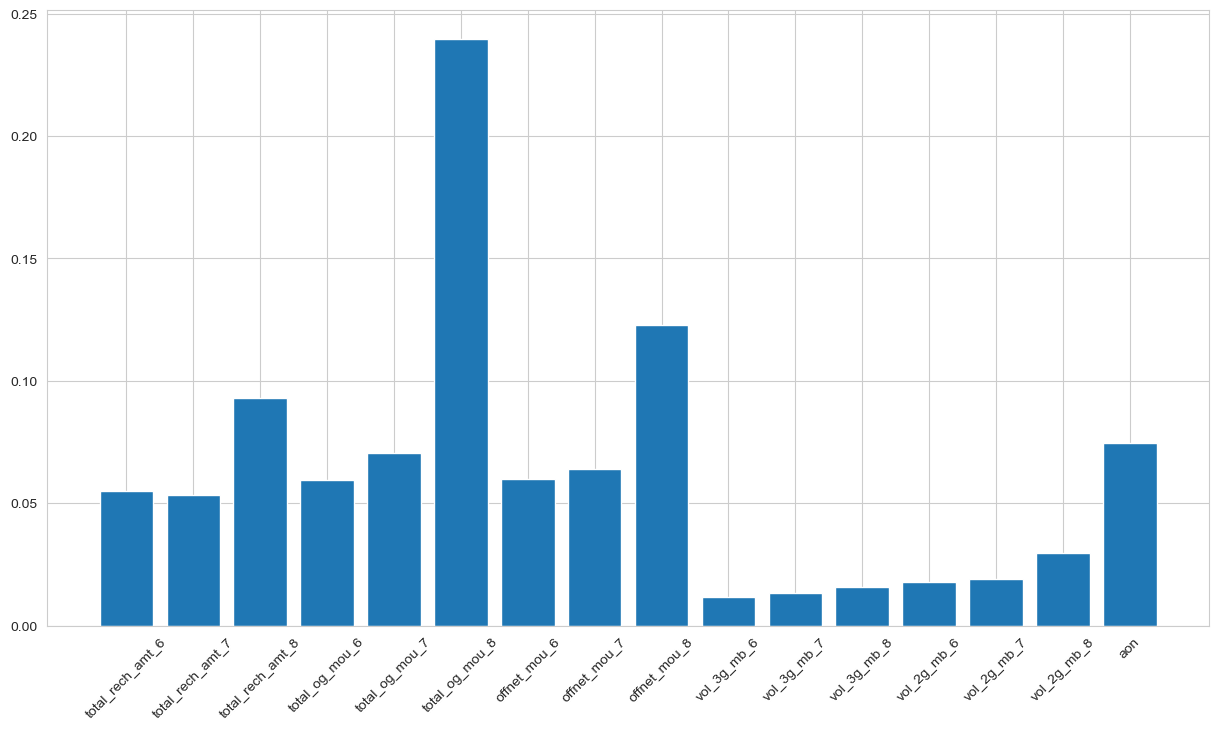

In [354]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<Axes: >

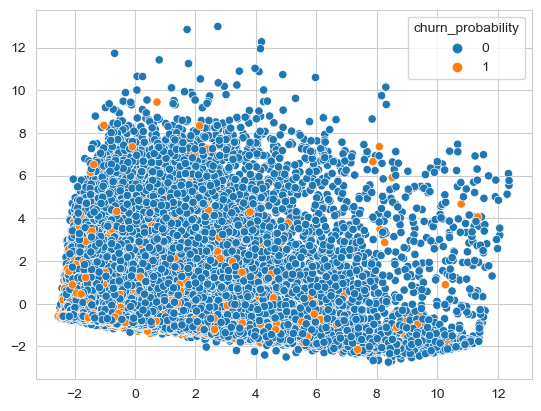

In [355]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

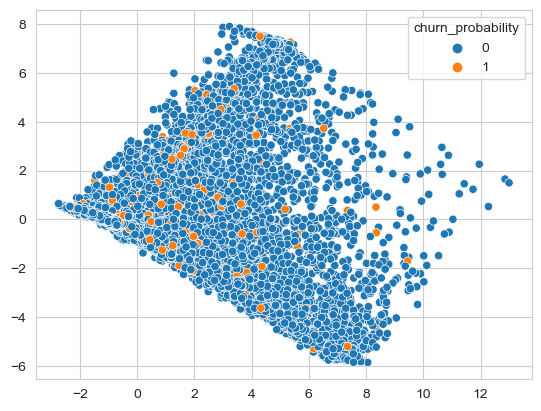

In [356]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 16 artists>

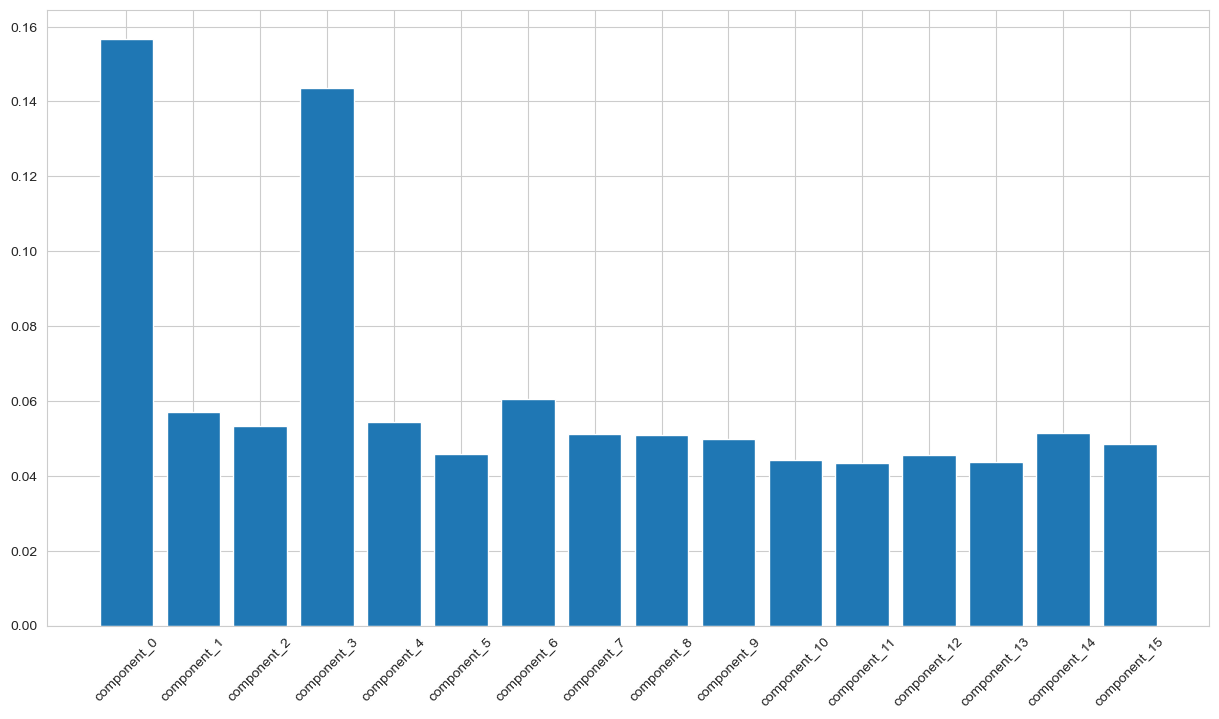

In [357]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

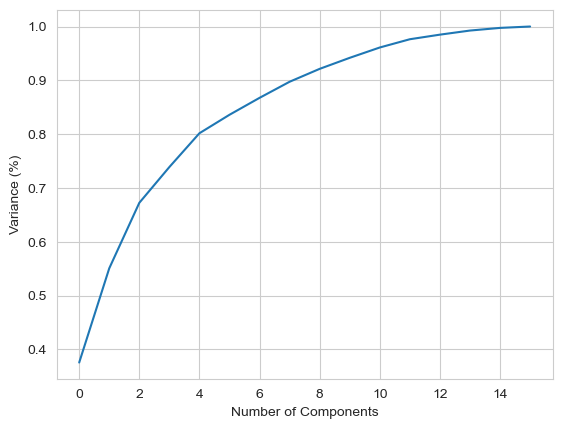

In [358]:
import matplotlib.pyplot as plt

# Plot variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # Explained variance
plt.show()

## <font color='Brown'>(1) Logistic Regression Model without PCA (using RFE)

**Checking the Correlation between independent variables (multicollinearity)**

In [359]:
##Rewriting original dataframe 'telecom_hv'
telecom_hv = data.copy()

In [360]:
df_corr = telecom_hv.drop(['churn_probability'], axis=1)
my_corr_matrix = df_corr.corr().abs()

# Create an upper triangle matrix
upper_triangle = my_corr_matrix.where(np.triu(np.ones(my_corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop
cols_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.70)]

# Print the columns to drop
print("Columns to drop due to high correlation:")
print(cols_to_drop)

Columns to drop due to high correlation:
['total_rech_amt_7', 'total_rech_amt_8', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']


In [361]:
##Dropping the strongly correlated variables 'cols_to_drop' from 'telecom_hv' dataframe
telecom_hv.drop(cols_to_drop, axis=1, inplace= True)

In [362]:
telecom_hv.shape

(69999, 9)

In [363]:
##Creating a function to find binary value columns from the 'telecom_hv' dataframe (if any)
def binary_val_cols(df):
    df_1 = df.copy()
    dualsvcol = (df_1.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol

binary_cols = binary_val_cols(df= telecom_hv)
print(binary_cols)

['churn_probability']


**Train-Test Split:**

In [364]:
##split into train and test
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(telecom_hv, train_size=0.7, test_size = 0.3, random_state=42)

#### Feature Scaling

In [365]:
##Dataframe with binary columns
df_binary_train = df_train.loc[:, binary_cols]
df_binary_test = df_test.loc[:, binary_cols]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = df_train.drop(binary_cols, axis=1)
df_test = df_test.drop(binary_cols, axis=1)

##StandardScaler
from sklearn.preprocessing import StandardScaler
all_cols = df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
#concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])
#concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

In [366]:
print(df_train.shape)
print(df_test.shape)

(48999, 9)
(21000, 9)


In [367]:
##Scaled train-data
df_train.head()

,circle_id,total_rech_amt_6,total_og_mou_6,arpu_3g_6,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,
61787,0.0,0.492728,0.891797,NaN,-0.241486,-0.242288,-0.233481,-0.786384,0
19961,0.0,-0.593916,-0.656023,-0.463508,0.664400,1.205150,0.891214,-0.675875,0
11040,0.0,0.338594,-0.310982,NaN,-0.241486,-0.242288,-0.233481,2.026842,0
27673,0.0,0.068860,0.618627,NaN,-0.241486,-0.242288,-0.233481,-0.703239,0
22876,0.0,-0.845669,-0.534588,NaN,-0.241486,-0.242288,-0.233481,-0.731656,0


In [368]:
##Storing target variable to y_train and y_test respectively
y_train = df_train['churn_probability']
y_test = df_test['churn_probability']

##Storing all feature variables to X_train and X_test
X_train = df_train.drop('churn_probability',axis=1)
X_test = df_test.drop('churn_probability',axis=1)

In [369]:
##Dealing with class imbalance using SMOTE
y= telecom_hv['churn_probability']
print("Before OverSampling, counts of label '1'(train_set): {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0'(train_set): {} \n".format(sum(y_train==0)))
print("Before OverSampling, churn event rate (Entire Dataset): {}% \n".format(round(sum(y==1)/len(y)*100,3)))

Before OverSampling, counts of label '1'(train_set): 4977
Before OverSampling, counts of label '0'(train_set): 44022 

Before OverSampling, churn event rate (Entire Dataset): 10.189% 



In [370]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# Impute missing values in X_train and X_test using mean strategy
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Logistic regression object
lr = LogisticRegression() 

# Train the model on the train set
lr.fit(X_train_imputed, y_train.ravel()) 

# Make predictions on the test set
predictions = lr.predict(X_test_imputed) 

# Print classification report
print(classification_report(y_test, predictions, target_names=['Not Churned', 'Churned']))


              precision    recall  f1-score   support

 Not Churned       0.90      1.00      0.95     18845
     Churned       0.00      0.00      0.00      2155

    accuracy                           0.90     21000
   macro avg       0.45      0.50      0.47     21000
weighted avg       0.81      0.90      0.85     21000



**Observations:**<br>(i) The `accuracy` is around 93% but it `doesn't serve as a good evaluation metric` as the `classes are imbalanced` in the dataset.<br>
(ii) The `recall of Churned i.e. positive label (Sensitivity)` is 0.26 is `low` and the `recall of Not Churned i.e. negative label (Specificity)` is `high`, almost 1 (0.99).<br>
(iii) This is not desired since we need to reduce the False Negatives. `For better prediction of Churned (Postive Labels)`, the `sensitivity has to be high`.

In [371]:
# Import necessary libraries
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

# Impute missing values in X_train using mean strategy
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Initialize SMOTETomek
smote_tomek = SMOTETomek(random_state=42)

# Apply SMOTETomek to the imputed training data
X_res, y_res = smote_tomek.fit_resample(X_train_imputed, y_train)

# Display results
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))
print("After OverSampling, churn event rate : {}% \n".format(round(sum(y_res==1)/len(y_res)*100, 2)))


After OverSampling, the shape of train_X: (84518, 8)
After OverSampling, the shape of train_y: (84518,) 

After OverSampling, counts of label '1': 42259
After OverSampling, counts of label '0': 42259
After OverSampling, churn event rate : 50.0% 



**Model Building:** Running Your First Training Model

In [372]:
import statsmodels.api as sm

In [373]:
import statsmodels.api as sm

# Build and fit the logistic regression model
logm1 = sm.GLM(y_res, sm.add_constant(X_res), family=sm.families.Binomial())
result = logm1.fit()

# Print summary
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                84518
Model:                            GLM   Df Residuals:                    84510
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54423.
Date:                Tue, 10 Sep 2024   Deviance:                   1.0885e+05
Time:                        20:56:55   Pearson chi2:                 4.85e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09375
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2304      0.008    -27.356      0.0

In [374]:
logreg = LogisticRegression()   ##Class imbalance dealt using SMOTE
logreg

LogisticRegression()

In [375]:
# Import necessary libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model
logreg = LogisticRegression()

# Initialize RFE with logistic regression estimator and number of features to select
rfe = RFE(estimator=logreg, n_features_to_select=25)

# Fit RFE on the resampled training data
rfe = rfe.fit(X_res, y_res)

# Print the rankings of the features
print("Feature ranking:")
print(rfe.ranking_)


Feature ranking:
[1 1 1 1 1 1 1 1]


In [376]:
# Create a list of feature names (e.g., feature_1, feature_2, etc.)
feature_names = [f'feature_{i+1}' for i in range(X_res.shape[1])]

# Zip the column names with RFE support and ranking
feature_info = list(zip(feature_names, rfe.support_, rfe.ranking_))

# Print the feature information
for feature in feature_info:
    print(f"Feature: {feature[0]}, Selected: {feature[1]}, Ranking: {feature[2]}")


Feature: feature_1, Selected: True, Ranking: 1
Feature: feature_2, Selected: True, Ranking: 1
Feature: feature_3, Selected: True, Ranking: 1
Feature: feature_4, Selected: True, Ranking: 1
Feature: feature_5, Selected: True, Ranking: 1
Feature: feature_6, Selected: True, Ranking: 1
Feature: feature_7, Selected: True, Ranking: 1
Feature: feature_8, Selected: True, Ranking: 1


In [377]:
# Create a list of feature names (e.g., feature_1, feature_2, etc.)
feature_names = [f'feature_{i+1}' for i in range(X_res.shape[1])]

# Get the supported feature names
col_rfe_sup = [feature for feature, support in zip(feature_names, rfe.support_) if support]
print(col_rfe_sup)


['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']


In [378]:
import pandas as pd

# Assuming you have the original feature names in feature_names
feature_names = X_train.columns.tolist()  # or your list of feature names

# Generate the list of supported feature names
col_rfe_sup = [feature for feature, support in zip(feature_names, rfe.support_) if support]

# Create a DataFrame with RFE selected features
X_res_rfe = pd.DataFrame(X_res, columns=feature_names)[col_rfe_sup]

# Display the DataFrame
print(X_res_rfe.head())


   circle_id  total_rech_amt_6  total_og_mou_6     arpu_3g_6  vol_2g_mb_6  \
0        0.0          0.492728        0.891797  4.613539e-17    -0.241486   
1        0.0         -0.593916       -0.656023 -4.635082e-01     0.664400   
2        0.0          0.338594       -0.310982  4.613539e-17    -0.241486   
3        0.0          0.068860        0.618627  4.613539e-17    -0.241486   
4        0.0         -0.049310       -0.393803  4.613539e-17    -0.241486   

   vol_2g_mb_7  vol_2g_mb_8       aon  
0    -0.242288    -0.233481 -0.786384  
1     1.205150     0.891214 -0.675875  
2    -0.242288    -0.233481  2.026842  
3    -0.242288    -0.233481 -0.703239  
4    -0.242288    -0.233481 -0.906364  


In [379]:
##Defining a function for VIFs (variation inflation factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

def mod_vif(X_res_set):
    telecom_hv = pd.DataFrame()
    X = X_res_set
    telecom_hv['Features'] = X.columns
    telecom_hv['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    telecom_hv['VIF'] = round(telecom_hv['VIF'], 2)
    telecom_hv = telecom_hv.sort_values(by = "VIF", ascending = False)
    telecom_hv = telecom_hv[~(telecom_hv.Features=='const')] #Ignore the constant from the display
    return telecom_hv

In [380]:
##Building Model 1: 
X_res_rfe = sm.add_constant(X_res_rfe)
logm3 = sm.GLM(y_res,X_res_rfe, family = sm.families.Binomial())
res = logm3.fit()
print(res.summary())

##Checking VIFs of independent variables
mod_vif(X_res_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                84518
Model:                            GLM   Df Residuals:                    84510
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54423.
Date:                Tue, 10 Sep 2024   Deviance:                   1.0885e+05
Time:                        20:56:56   Pearson chi2:                 4.85e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09375
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2304      0.008  

,Features,VIF
2,total_rech_amt_6,2.00
6,vol_2g_mb_7,1.92
3,total_og_mou_6,1.87
7,vol_2g_mb_8,1.59
5,vol_2g_mb_6,1.55
4,arpu_3g_6,1.13
8,aon,1.00
1,circle_id,NaN


**Observations:**<br>From the statistics summary, we conclude that the `model is stable`

In [381]:
##Getting the predicted values on the train set
y_res_pred = res.predict(X_res_rfe)
y_res_pred[:10]

0    0.617659
1    0.366606
2    0.218332
3    0.597389
4    0.619181
5    0.504953
6    0.595902
7    0.591823
8    0.301693
9    0.620962
dtype: float64

In [382]:
y_res_pred = y_res_pred.values.reshape(-1)
y_res_pred[:10]

array([0.61765853, 0.36660552, 0.21833212, 0.59738865, 0.61918052,
       0.50495277, 0.59590169, 0.59182349, 0.30169337, 0.62096169])

In [383]:
y_res_pred_final = pd.DataFrame({'Churn':y_res.values, 'Churn_Prob':y_res_pred})
y_res_pred_final['CustID'] = y_res.index    ##CustID is the record index ID
y_res_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.617659,0
1,0,0.366606,1
2,0,0.218332,2
3,0,0.597389,3
4,0,0.619181,4


In [384]:
y_res_pred_final['predicted'] = y_res_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_res_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.617659,0,1
1,0,0.366606,1,0
2,0,0.218332,2,0
3,0,0.597389,3,1
4,0,0.619181,4,1


In [385]:
##Defining a function to plot confusion matrix

from sklearn import metrics
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Not Churned','Churned']
    cmap=plt.cm.Reds
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test,y_pred,model_name):
    print(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()

Logistic Regression (without) PCA) Model Stats Scores Summary : 


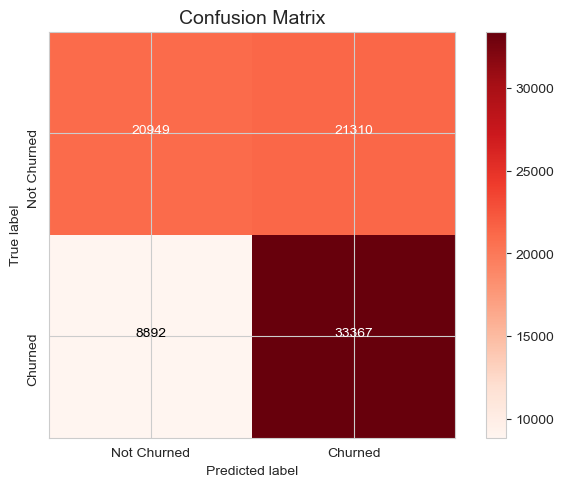

In [386]:
##Confusion matrix 
from sklearn import metrics
confusion = metrics.confusion_matrix(y_res_pred_final.Churn, y_res_pred_final.predicted)
print_model_metrics(y_res_pred_final.Churn, y_res_pred_final.predicted,'Logistic Regression (without) PCA)')

In [387]:
# Let's check the overall accuracy. (train_data)---Balanced classes
print(metrics.accuracy_score(y_res_pred_final.Churn, y_res_pred_final.predicted))

0.6426560022717054


In [388]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='(ROC-AUC = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [389]:
fpr, tpr, thresholds = metrics.roc_curve( y_res_pred_final.Churn, y_res_pred_final.Churn_Prob, drop_intermediate = False )

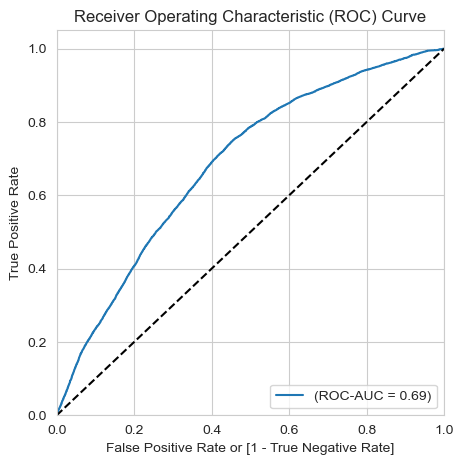

In [390]:
##ROC curve for train data
draw_roc(y_res_pred_final.Churn, y_res_pred_final.Churn_Prob)

In [391]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_res_pred_final[i]= y_res_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_res_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.617659,0,1,1,1,1,1,1,1,1,0,0,0
1,0,0.366606,1,0,1,1,1,1,0,0,0,0,0,0
2,0,0.218332,2,0,1,1,1,0,0,0,0,0,0,0
3,0,0.597389,3,1,1,1,1,1,1,1,0,0,0,0
4,0,0.619181,4,1,1,1,1,1,1,1,1,0,0,0


In [392]:
##Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_res_pred_final.Churn, y_res_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.511879  0.995338  0.028420
0.2   0.2  0.532478  0.981424  0.083533
0.3   0.3  0.578776  0.930950  0.226603
0.4   0.4  0.610781  0.879671  0.341892
0.5   0.5  0.642656  0.789583  0.495729
0.6   0.6  0.608285  0.428098  0.788471
0.7   0.7  0.503076  0.008543  0.997610
0.8   0.8  0.500024  0.000213  0.999834
0.9   0.9  0.500012  0.000047  0.999976


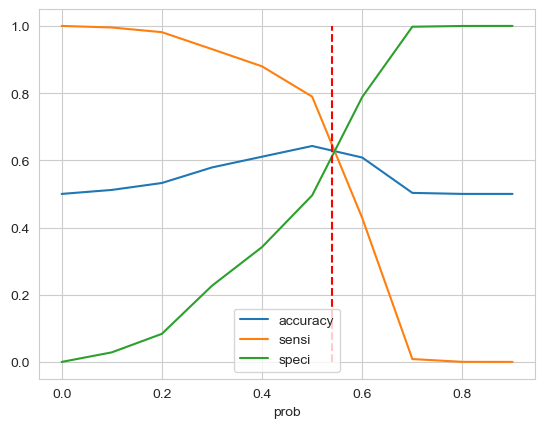

In [393]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
%matplotlib inline
sns.set_style('whitegrid')
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.54, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

In [394]:
y_res_pred_final['final_predicted'] = y_res_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.54 else 0)
y_res_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.617659,0,1,1,1,1,1,1,1,1,0,0,0,1
1,0,0.366606,1,0,1,1,1,1,0,0,0,0,0,0,0
2,0,0.218332,2,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.597389,3,1,1,1,1,1,1,1,0,0,0,0,1
4,0,0.619181,4,1,1,1,1,1,1,1,1,0,0,0,1


Logistic Regression (without) PCA) Model Stats Scores Summary : 


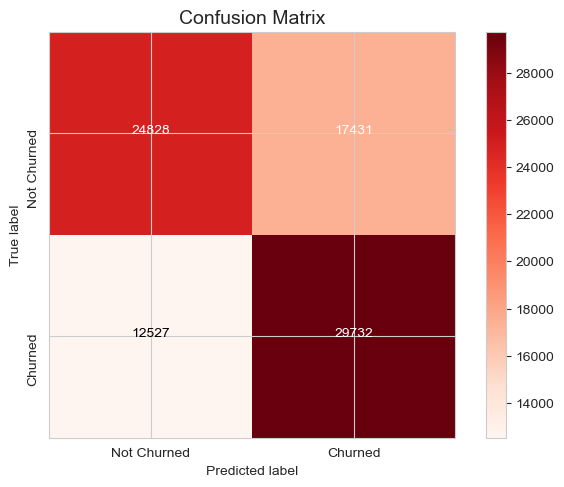

In [395]:
##Confusion Matrix (optimal train set) 
confusion_train_opt = metrics.confusion_matrix(y_res_pred_final.Churn, y_res_pred_final.final_predicted)
print_model_metrics(y_res_pred_final.Churn, y_res_pred_final.final_predicted,'Logistic Regression (without) PCA)')

In [396]:
##Define a function for other evaluation metrics:
def other_metrics_logistic_model(confusion):
    
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    sensitivity= round((TP) / (TP+FN),4) #sensitivity of our logistic regression model
    specificity= round((TN) / (TN+FP),4) #specificity  of our logistic regression model   
    FPR= round((FP) / (TN+FP),4)        #False Positive Rate - predicting churn when customer does not have churned
    positive_pred_val= round((TP) / (TP+FP),4)  #Positive predictive value
    negative_pred_val= round((TN) / (TN+ FN),4) #Negative predictive value
    misclass_rate = round((FN+FP)/(TP+TN+FP+FN),4)  #Misclassification rate
    
    metric_list= ['Sensitivity', 'Specificity', 'False Positive Rate','Positive Predictive Value','Negative Predictive Value', 'Misclassification Rate']
    metric_val = [sensitivity, specificity, FPR, positive_pred_val, negative_pred_val, misclass_rate]
    evaluation_metrics_df=pd.DataFrame({'Evaluation Metrics':metric_list, 'Value': metric_val})
    evaluation_metrics_df.set_index('Evaluation Metrics', inplace= True)
    return evaluation_metrics_df

In [397]:
##Let's evaluate Evaluation Metrics (train_data)
print("******************************************************************")
print('Accuracy of Train Set: (Logistic Regression Model without PCA):')
print(metrics.accuracy_score(y_res_pred_final.Churn, y_res_pred_final.final_predicted))
print("******************************************************************")

print(classification_report(y_res_pred_final.Churn, y_res_pred_final.final_predicted, target_names=['Not Churned','Churned']))
print("******************************************************************")

print(other_metrics_logistic_model(confusion_train_opt))
print("******************************************************************")
print('ROC of Train Set: (Logistic Regression Model without PCA):')
print("{:2.3}".format(metrics.roc_auc_score(y_res_pred_final.Churn, y_res_pred_final.Churn_Prob)))


******************************************************************
Accuracy of Train Set: (Logistic Regression Model without PCA):
0.6455429612626896
******************************************************************
              precision    recall  f1-score   support

 Not Churned       0.66      0.59      0.62     42259
     Churned       0.63      0.70      0.66     42259

    accuracy                           0.65     84518
   macro avg       0.65      0.65      0.64     84518
weighted avg       0.65      0.65      0.64     84518

******************************************************************
                            Value
Evaluation Metrics               
Sensitivity                0.7036
Specificity                0.5875
False Positive Rate        0.4125
Positive Predictive Value  0.6304
Negative Predictive Value  0.6646
Misclassification Rate     0.3545
******************************************************************
ROC of Train Set: (Logistic Regression Model witho

**Observation:**<br>Using the optimal cut-off,<br>(i) `ROC_AUC` of test set: `0.885`<br>(ii) `Recall Score` of test set: `0.76`.

Top 10 Features Based on Feature Importance:

In [398]:
X_res = pd.DataFrame(X_res, columns=X_train.columns)

# Create a DataFrame with selected features
selected_features = X_res.columns[rfe.support_]
X_res_rfe = X_res[selected_features]

# Coefficients of features
rfe_coef_list = np.array(rfe.estimator_.coef_.flatten().round(4))

# Create a DataFrame of features and coefficients
rfe_df = pd.DataFrame({
    'Features': selected_features,
    'Coefficients': rfe_coef_list,
    'Abs_Coefficients (Desc_Sort)': abs(rfe_coef_list)
})

# Sorting coefficients in descending order of absolute values and reset index to 'Features'
rfe_df = rfe_df.sort_values(by='Abs_Coefficients (Desc_Sort)', ascending=False)
rfe_df["Rank (Feature Importance Based)"] = rfe_df["Abs_Coefficients (Desc_Sort)"].rank(ascending=False)
rfe_df.drop('Abs_Coefficients (Desc_Sort)', axis=1, inplace=True)
rfe_df.set_index('Features', inplace=True)

print(rfe_df)

                  Coefficients  Rank (Feature Importance Based)
Features                                                       
vol_2g_mb_8            -0.8089                              1.0
aon                    -0.6098                              2.0
total_rech_amt_6        0.0653                              3.0
vol_2g_mb_6             0.0376                              4.0
total_og_mou_6          0.0244                              5.0
vol_2g_mb_7             0.0138                              6.0
arpu_3g_6              -0.0125                              7.0
circle_id               0.0000                              8.0


In [399]:
##Top 15 features (feature importance based ranking)

##Getting Top15 features
top15_df= rfe_df[:15]
top15_df

print('*'*70)
print(top15_df)

**********************************************************************
                  Coefficients  Rank (Feature Importance Based)
Features                                                       
vol_2g_mb_8            -0.8089                              1.0
aon                    -0.6098                              2.0
total_rech_amt_6        0.0653                              3.0
vol_2g_mb_6             0.0376                              4.0
total_og_mou_6          0.0244                              5.0
vol_2g_mb_7             0.0138                              6.0
arpu_3g_6              -0.0125                              7.0
circle_id               0.0000                              8.0


## <font color='Brown'> (1.1) Logistic Regression Model (with PCA)

In [400]:
##Rewriting original dataframe 'telecom_hv'
telecom_hv = data.copy()

In [401]:
telecom_hv.shape

(69999, 24)

In [402]:
##Creating a function to find binary value columns from the 'telecom_hv' dataframe (if any)
def binary_val_cols(df):
    df_1 = df.copy()
    dualsvcol = (df_1.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol

binary_cols = binary_val_cols(df= telecom_hv)
print(binary_cols)

['churn_probability']


In [403]:
##Split into train and test
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(telecom_hv, train_size=0.7, test_size = 0.3, random_state=42)

In [404]:
##Dataframe with binary columns
df_binary_train = df_train.loc[:, binary_cols]
df_binary_test = df_test.loc[:, binary_cols]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = df_train.drop(binary_cols, axis=1)
df_test = df_test.drop(binary_cols, axis=1)

##StandardScaler
from sklearn.preprocessing import StandardScaler
all_cols = df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
#concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])
#concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

In [405]:
print(df_train.shape)
print(df_test.shape)

(48999, 24)
(21000, 24)


In [406]:
##Scaled train-data
df_train.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
61787,0.0,0.492728,0.740794,0.844283,0.891797,1.617612,2.001507,1.440413,2.386081,3.112260,...,NaN,NaN,-0.215311,-0.235681,-0.234631,-0.241486,-0.242288,-0.233481,-0.786384,0
19961,0.0,-0.593916,-0.583337,-0.659695,-0.656023,-0.646303,-0.606658,-0.623624,-0.609545,-0.608499,...,-0.498221,-0.496435,-0.215311,-0.235681,-0.234631,0.664400,1.205150,0.891214,-0.675875,0
11040,0.0,0.338594,-0.182165,0.252346,-0.310982,0.045837,0.177566,0.012912,0.315687,0.241729,...,NaN,NaN,-0.215311,-0.235681,-0.234631,-0.241486,-0.242288,-0.233481,2.026842,0
27673,0.0,0.068860,-0.688219,-0.695262,0.618627,-0.494439,-0.613473,-0.080120,-0.549769,-0.609929,...,NaN,NaN,-0.215311,-0.235681,-0.234631,-0.241486,-0.242288,-0.233481,-0.703239,0
22876,0.0,-0.845669,-0.819321,-0.466617,-0.534588,-0.512233,-0.403322,-0.470888,-0.503023,-0.374770,...,NaN,NaN,-0.215311,-0.235681,-0.234631,-0.241486,-0.242288,-0.233481,-0.731656,0


In [407]:
##Storing target variable to y_train and y_test respectively
y_train = df_train['churn_probability']
y_test = df_test['churn_probability']

##Storing all feature variables to X_train and X_test
X_train = df_train.drop('churn_probability',axis=1)
X_test = df_test.drop('churn_probability',axis=1)

In [408]:
##Dealing with class imbalance using SMOTE
y= telecom_hv['churn_probability']
print("Before OverSampling, counts of label '1'(train_set): {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0'(train_set): {} \n".format(sum(y_train==0)))
print("Before OverSampling, churn event rate (Entire Dataset): {}% \n".format(round(sum(y==1)/len(y)*100,3)))

Before OverSampling, counts of label '1'(train_set): 4977
Before OverSampling, counts of label '0'(train_set): 44022 

Before OverSampling, churn event rate (Entire Dataset): 10.189% 



In [409]:
# Check and handle missing values
# Assuming we are imputing missing values here
from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Impute missing values
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create and train the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train_imputed, y_train.ravel())

# Predictions and classification report for training data
predictions_train = lr.predict(X_train_imputed)
classification_report_base_mod_train = classification_report(y_train, predictions_train, target_names=['Not Churned','Churned'])
print("For Train Set (Class Imbalance Dataset):\n", classification_report_base_mod_train)

# Predictions and classification report for test data
predictions = lr.predict(X_test_imputed)
classification_report_base_mod_test = classification_report(y_test, predictions, target_names=['Not Churned','Churned'])
print("For Test Set (Class Imbalance Dataset):\n", classification_report_base_mod_test)


For Train Set (Class Imbalance Dataset):
               precision    recall  f1-score   support

 Not Churned       0.93      0.99      0.96     44022
     Churned       0.79      0.33      0.47      4977

    accuracy                           0.92     48999
   macro avg       0.86      0.66      0.71     48999
weighted avg       0.91      0.92      0.91     48999

For Test Set (Class Imbalance Dataset):
               precision    recall  f1-score   support

 Not Churned       0.93      0.99      0.96     18845
     Churned       0.78      0.32      0.46      2155

    accuracy                           0.92     21000
   macro avg       0.86      0.66      0.71     21000
weighted avg       0.91      0.92      0.91     21000



**Observations:**<br>(i) The `accuracy` is around 93% but it `doesn't serve as a good evaluation metric` as the `classes are imbalanced` in the dataset.<br>
(ii) The `recall of Churned i.e. positive label (Sensitivity)` is 0.29 is `low` and the `recall of Not Churned i.e. negative label (Specificity)` is `high`, almost 1 (0.99).<br>
(iii) This is not desired since we need to reduce the False Negatives. `For better prediction of Churned (Postive Labels)`, the `sensitivity has to be high` and `Specificity (recall for Not Churned) has to be low`.

In [410]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a strategy (mean, median, most_frequent, constant)
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent', 'constant'

# Fit the imputer on the training data and transform both train and test sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply SMOTETomek on the imputed training data
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train_imputed, y_train)

# Storing the balanced class X_res and y_res values for future models with PCA
X_res_pca_smote_tomek = X_res.copy()
y_res_pca_smote_tomek = y_res.copy()

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))
print("After OverSampling, churn event rate : {}% \n".format(round(sum(y_res==1)/len(y_res)*100,2)))


After OverSampling, the shape of train_X: (87712, 23)
After OverSampling, the shape of train_y: (87712,) 

After OverSampling, counts of label '1': 43856
After OverSampling, counts of label '0': 43856
After OverSampling, churn event rate : 50.0% 



In [505]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=42, n_components=0.9)
pca.fit(X_res)

PCA(n_components=0.9, random_state=42)

In [506]:
pca.components_

array([[ 0.00000000e+00,  3.42723150e-01,  3.47565625e-01,
         2.63562035e-01,  3.82207852e-01,  3.84056651e-01,
         2.79287072e-01,  3.53489072e-01,  3.46133541e-01,
         2.42877147e-01,  3.12864452e-02,  3.07004985e-02,
         2.36667909e-02,  2.89999867e-02,  2.93362019e-02,
         2.21460027e-02,  6.20932342e-02,  6.64130097e-02,
         6.09929911e-02,  2.87644530e-03,  1.02738966e-02,
         1.04785745e-02,  7.38796241e-03],
       [ 0.00000000e+00,  7.91613688e-02,  1.01143531e-01,
         1.27192443e-01, -1.51501937e-01, -1.11342407e-01,
        -4.36107140e-02, -1.49355191e-01, -1.15648814e-01,
        -4.97086543e-02,  2.05495799e-01,  1.88149779e-01,
         1.64042646e-01,  2.05446850e-01,  1.86978372e-01,
         1.68214709e-01,  5.13212655e-01,  4.70945039e-01,
         4.16275480e-01,  9.61657472e-02,  8.76569395e-02,
         7.80991286e-02,  2.05901158e-02],
       [-0.00000000e+00, -1.74875409e-02,  7.74375514e-02,
         1.04890659e-01, -7.3

In [507]:
pca.explained_variance_ratio_

array([0.32602509, 0.15248775, 0.10364457, 0.08420739, 0.05721072,
       0.04398258, 0.03667303, 0.03345278, 0.03015564, 0.02838811,
       0.01880098])

In [508]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

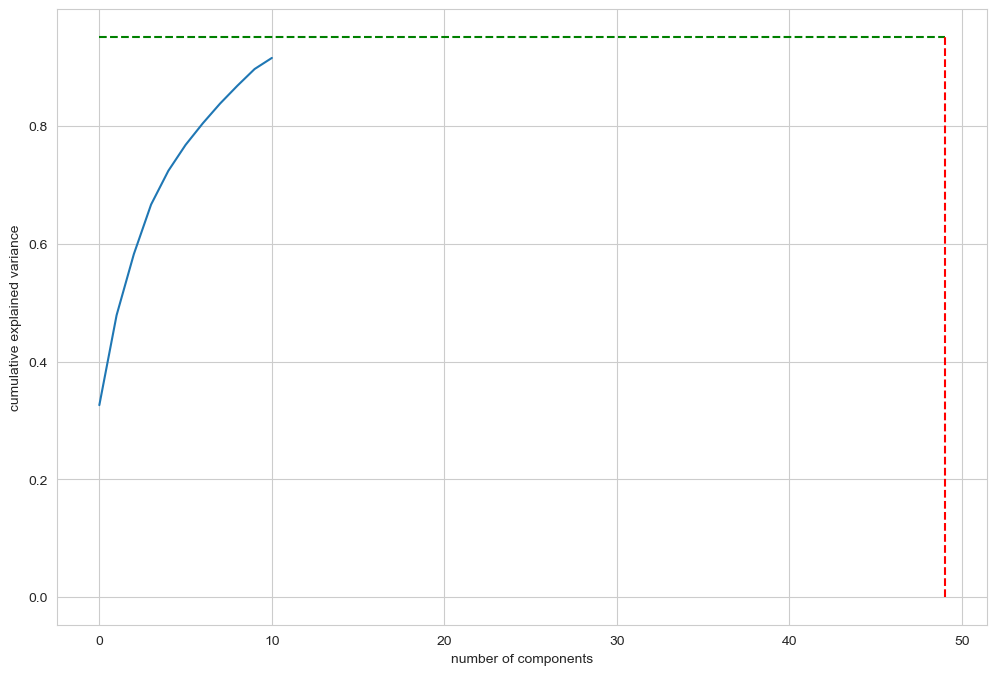

In [509]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize = (12,8))
plt.plot(var_cumu)
plt.hlines(y=0.95, xmax=49, xmin=0, colors="g", linestyles="--")
plt.vlines(x=49, ymax=0.95, ymin=0, colors="r", linestyles="--")  ##Optimal number of features-> 49, explains 95% variance
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [510]:
from sklearn.decomposition import IncrementalPCA
from sklearn import metrics

# Set n_components to the number of features in X_res (23 in this case)
n_components = min(X_res.shape[1], 23)  # Or any value <= 23

# Create and apply IncrementalPCA
pca_final = IncrementalPCA(n_components=11)
df_train_pca = pca_final.fit_transform(X_res)

# Output the shape of the transformed data
print("Shape of the transformed data:", df_train_pca.shape)


Shape of the transformed data: (87712, 11)


<Axes: >

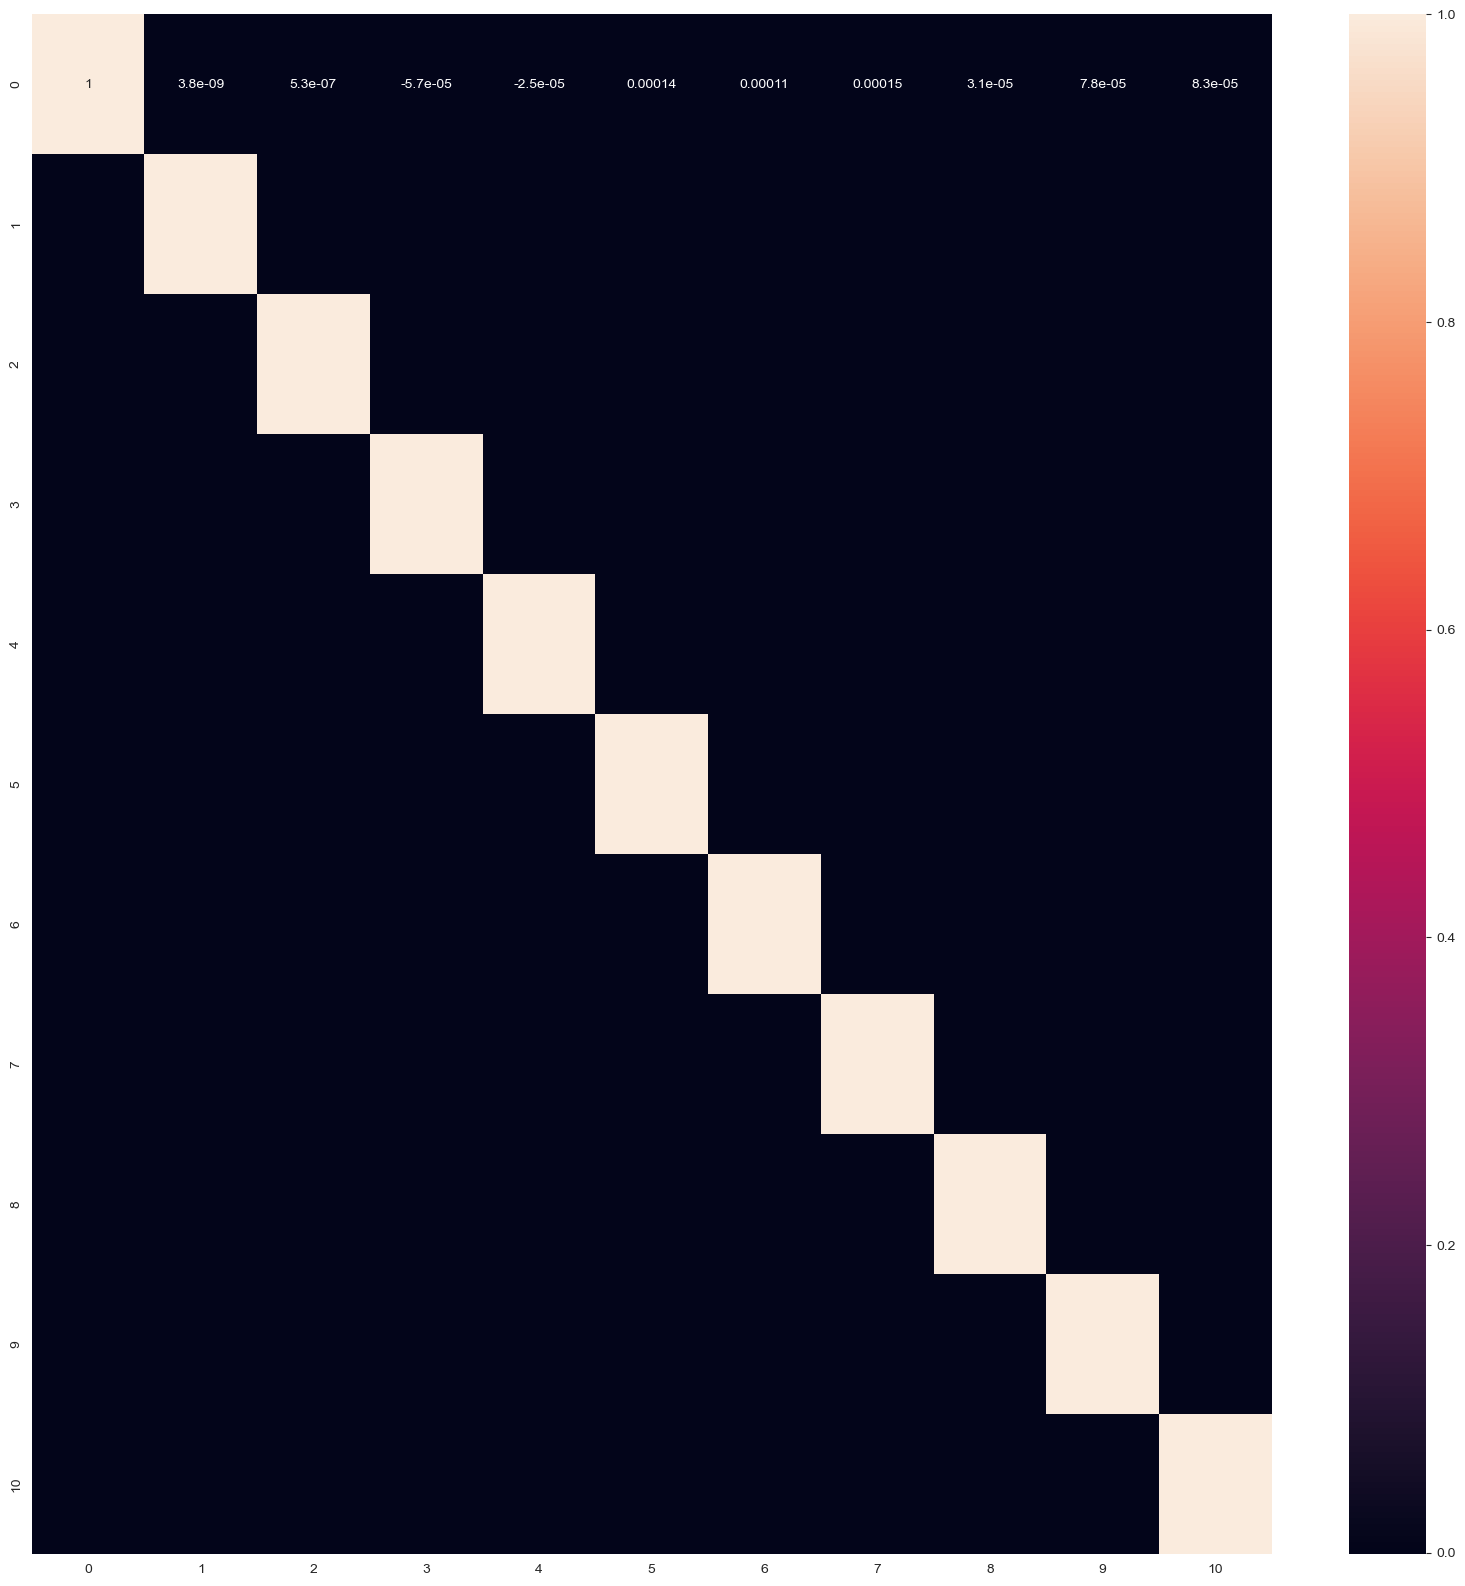

In [511]:
##Heatmap of PCA components
corrmat = np.corrcoef(df_train_pca.transpose())  ##Correlation matrix
plt.figure(figsize=[20,20])
sns.heatmap(corrmat, annot=True)

In [512]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a strategy, e.g., mean imputation
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply IncrementalPCA on the imputed data
pca_final = IncrementalPCA(n_components=n_components)
df_train_pca = pca_final.fit_transform(X_train_imputed)
df_test_pca = pca_final.transform(X_test_imputed)

print("Shape of the transformed test data:", df_test_pca.shape)


Shape of the transformed test data: (21000, 23)


In [513]:
##Note: Copy these variables for future models using pca
X_train_pca = df_train_pca
y_train_pca = y_res
X_test_pca = df_test_pca
y_test_pca = y_test

Applying Logistic Regression on the data (on principal components)
Let's check

(i) Logistic Regression (with PCA and without hyperparameter-tuning)

(ii) Logistic Regression (with PCA and hyperparameter-tuning)

### <font color='Green'>(i) Logistic Regression (with PCA and without hyperparameter-tuning)

In [514]:
pca_final = PCA(0.85)  # Adjusting to the correct number of components based on features
df_train_pca = pca_final.fit_transform(X_res)


In [515]:
print(f"Shape of df_train_pca: {df_train_pca.shape}")
print(f"Shape of y_res: {y_res.shape}")

Shape of df_train_pca: (87712, 9)
Shape of y_res: (87712,)


In [516]:
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca, y_res)

In [517]:
pred_probs_train = model_pca.predict_proba(df_train_pca)

In [518]:
##Getting the predicted values on the train set
y_res_pred= pred_probs_train[:,1]   ##Getting churn probability values(1)
y_res_pred

array([0.1390965 , 0.4988858 , 0.13322358, ..., 0.28920005, 0.53953216,
       0.99211506])

In [519]:
y_res_pred_final = pd.DataFrame({'Churn':y_res.values, 'Churn_Prob':y_res_pred})
y_res_pred_final['CustID'] = y_res.index    ##CustID is the record index ID
y_res_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.139097,0
1,0,0.498886,1
2,0,0.133224,2
3,0,0.705558,3
4,0,0.544460,4


In [520]:
y_res_pred_final['predicted'] = y_res_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_res_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.139097,0,0
1,0,0.498886,1,0
2,0,0.133224,2,0
3,0,0.705558,3,1
4,0,0.544460,4,1


Logistic Regression (with PCA) Model Stats Scores Summary : 


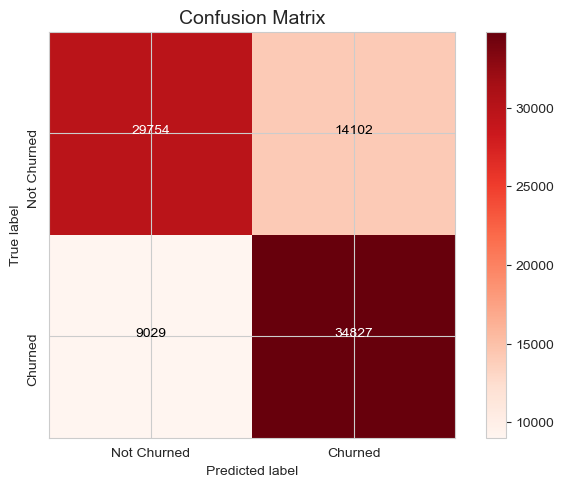

In [521]:
##Confusion Matrix 
confusion = metrics.confusion_matrix(y_res_pred_final.Churn, y_res_pred_final.predicted)
print_model_metrics(y_res_pred_final.Churn, y_res_pred_final.predicted,'Logistic Regression (with PCA)')

In [496]:
# Let's check the overall accuracy. (train_data)----Balanced Dataset
print(metrics.accuracy_score(y_res_pred_final.Churn, y_res_pred_final.predicted))

0.7362846588836192


###  Plotting the ROC Curve

In [497]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='(ROC-AUC = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [498]:
fpr, tpr, thresholds = metrics.roc_curve( y_res_pred_final.Churn, y_res_pred_final.Churn_Prob, drop_intermediate = False )

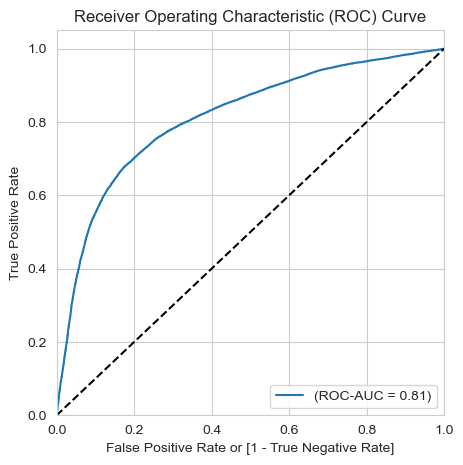

In [499]:
##ROC curve for train data
draw_roc(y_res_pred_final.Churn, y_res_pred_final.Churn_Prob)

In [500]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_res_pred_final[i]= y_res_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_res_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.139097,0,0,1,1,0,0,0,0,0,0,0,0
1,0,0.498886,1,0,1,1,1,1,1,0,0,0,0,0
2,0,0.133224,2,0,1,1,0,0,0,0,0,0,0,0
3,0,0.705558,3,1,1,1,1,1,1,1,1,1,0,0
4,0,0.544460,4,1,1,1,1,1,1,1,0,0,0,0


In [501]:
##Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_res_pred_final.Churn, y_res_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.553071  0.978407  0.127736
0.2   0.2  0.604649  0.956540  0.252759
0.3   0.3  0.655270  0.913307  0.397232
0.4   0.4  0.698194  0.859381  0.537007
0.5   0.5  0.736285  0.794122  0.678448
0.6   0.6  0.750935  0.673158  0.828712
0.7   0.7  0.670980  0.398554  0.943406
0.8   0.8  0.558361  0.133847  0.982876
0.9   0.9  0.521411  0.048500  0.994322


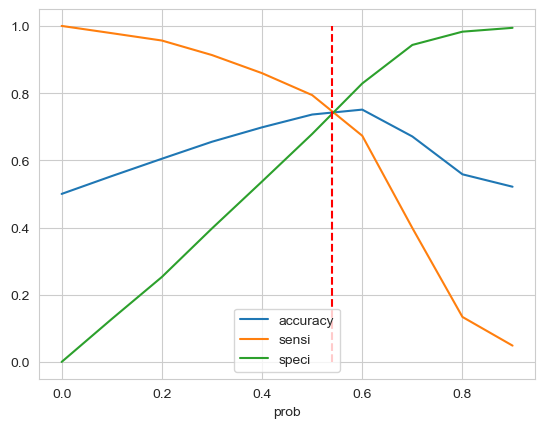

In [502]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
%matplotlib inline
sns.set_style('whitegrid')
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.54, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

In [503]:
y_res_pred_final['final_predicted'] = y_res_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.54 else 0)
y_res_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.139097,0,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.498886,1,0,1,1,1,1,1,0,0,0,0,0,0
2,0,0.133224,2,0,1,1,0,0,0,0,0,0,0,0,0
3,0,0.705558,3,1,1,1,1,1,1,1,1,1,0,0,1
4,0,0.544460,4,1,1,1,1,1,1,1,0,0,0,0,1


Logistic Regression (without) PCA) Model Stats Scores Summary : 


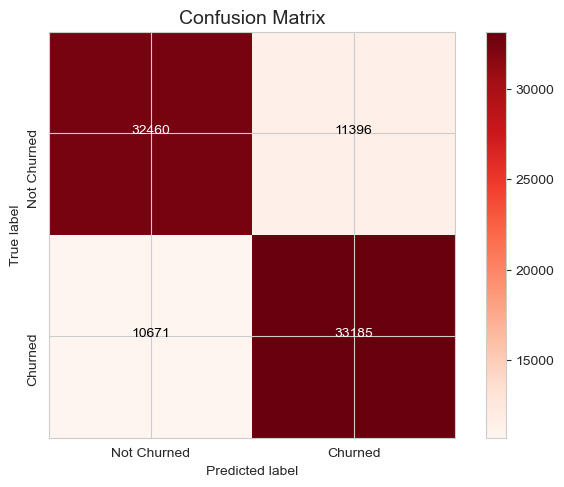

In [504]:
##Confusion Matrix (optimal train set) 
confusion_train_opt = metrics.confusion_matrix(y_res_pred_final.Churn, y_res_pred_final.final_predicted)
print_model_metrics(y_res_pred_final.Churn, y_res_pred_final.final_predicted,'Logistic Regression (without) PCA)')

In [ ]:
## Let's check the overall accuracy. (test_data)

print("******************************************************************")
print('Accuracy of Test Set: (Logistic Regression Model with PCA):')
accuracy_score_pca_no_hyp = metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted)
print(accuracy_score_pca_no_hyp)
print("******************************************************************")

from sklearn.metrics import classification_report
class_rep_pc_no_hyp = classification_report(y_test_pred_final.Churn, y_test_pred_final.predicted,\
                                         target_names=['Not Churned','Churned'])
print(class_rep_pc_no_hyp)  # target_names=target_names
print("******************************************************************")

confusion_test_opt_pca_no_hyp = confusion_test_opt
print(other_metrics_logistic_model(confusion_test_opt_pca_no_hyp))
print("******************************************************************")
print('ROC of Test Set: (Logistic Regression Model with PCA):')
auc_roc_pca_no_hyp = metrics.roc_auc_score(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob)
print("{:2.3}".format(auc_roc_pca_no_hyp))

******************************************************************
Accuracy of Test Set: (Logistic Regression Model with PCA):


NameError: name 'y_test_pred_final' is not defined

**Observation:**<br>After finding optimal cut-off,<br>(i) `ROC-AUC` of Train Set: `0.91`<br>(ii) `Recall Score` of Train Set: `0.84`

### Precision and Recall Trade-off

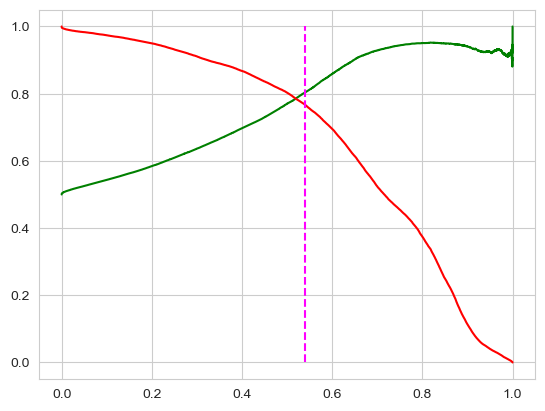

In [ ]:
from sklearn.metrics import precision_recall_curve
sns.set_style('whitegrid')

p, r, thresholds = precision_recall_curve(y_res_pred_final.Churn, y_res_pred_final.Churn_Prob)

plt.plot(thresholds, p[:-1], "g-")    ##Precision: Green-Line
plt.plot(thresholds, r[:-1], "r-")   ##Recall: Red-Line
plt.vlines(x=0.54, ymax=1, ymin=0, colors='magenta', linestyles="--")
plt.show()

### **Prediction and Evaluation: Test Set**

In [ ]:
# Check if 'const' is in the columns before attempting to drop it
if 'const' in X_res_rfe.columns:
    X_res_rfe.drop('const', axis=1, inplace=True)

# Now proceed with assigning similar columns to test data
X_test = X_test[X_res_rfe.columns]
X_test.head()


In [ ]:
##Adding the constant to X_test (as res model is based on statsmodels)
X_test_sm = sm.add_constant(X_test)
y_test_pred = res.predict(X_test_sm)

In [ ]:
##Getting the predicted values on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

In [ ]:
y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:10]

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [ ]:
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['CustID'] = y_test.index    ##CustID is the record index ID
y_test_pred_final.head()

##### Creating new column 'predicted' with 1 if Churn_Prob > 0.54 (optimal cut-off) else 0

In [ ]:
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.54 else 0)  ##optimal cut-off is 0.54
y_test_pred_final.head()

In [ ]:
##Confusion Matrix (optimal test set) 
confusion_test_opt = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.predicted)
print_model_metrics(y_test_pred_final.Churn, y_test_pred_final.predicted,'Logistic Regression (without) PCA)')

In [ ]:
## Let's check the overall accuracy. (test_data)

print("******************************************************************")
print('Accuracy of Test Set: (Logistic Regression Model with PCA):')
accuracy_score_pca_no_hyp = metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted)
print(accuracy_score_pca_no_hyp)
print("******************************************************************")

from sklearn.metrics import classification_report
class_rep_pc_no_hyp = classification_report(y_test_pred_final.Churn, y_test_pred_final.predicted,\
                                         target_names=['Not Churned','Churned'])
print(class_rep_pc_no_hyp)  # target_names=target_names
print("******************************************************************")

confusion_test_opt_pca_no_hyp = confusion_test_opt
print(other_metrics_logistic_model(confusion_test_opt_pca_no_hyp))
print("******************************************************************")
print('ROC of Test Set: (Logistic Regression Model with PCA):')
auc_roc_pca_no_hyp = metrics.roc_auc_score(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob)
print("{:2.3}".format(auc_roc_pca_no_hyp))

**Observation:**<br>Using the optimal cut-off,<br>(i) `ROC_AUC` of test set: `0.885`<br>


In [ ]:
##Creating a dataframe of features and coefficients

##Coefficients of features
rfe_coef_list = np.array(rfe.estimator_.coef_.round(4).tolist()[0]) 

rfe_df = pd.DataFrame({'Features':X_res_rfe.columns, 'Coefficients':rfe_coef_list, \
                         'Abs_Coefficients (Desc_Sort)':abs(rfe_coef_list)})

##Sorting coefficient in descending order of absolute coefficient values and reset index to 'Features'
rfe_df = rfe_df.sort_values(by='Abs_Coefficients (Desc_Sort)', ascending=False)
rfe_df["Rank (Feature Importance Based)"] = rfe_df["Abs_Coefficients (Desc_Sort)"].rank(ascending=False)
rfe_df.drop('Abs_Coefficients (Desc_Sort)', axis=1, inplace=True)
rfe_df.set_index('Features', inplace= True)
rfe_df

,Coefficients,Rank (Feature Importance Based)
Features,,
vol_2g_mb_8,-0.8089,1.0
aon,-0.6098,2.0
total_rech_amt_6,0.0653,3.0
vol_2g_mb_6,0.0376,4.0
total_og_mou_6,0.0244,5.0
vol_2g_mb_7,0.0138,6.0
arpu_3g_6,-0.0125,7.0
circle_id,0.0000,8.0


In [ ]:
##Top 15 features (feature importance based ranking)

##Getting Top15 features
top15_df= rfe_df[:15]
top15_df

print('*'*70)
print(top15_df)

### <font color='Green'>(ii) Logistic Regression (with PCA and hyperparameter-tuning)

In [522]:
# Example of grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2']
c_values = np.logspace(-3,3,10)   ##Lambda= 1/c_values (Here, c_values range from 0.001 to 1000)

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro',error_score=0)
grid_result = grid_search.fit(X=df_train_pca, y=y_res)   ##Note: (X,y) = (df_train_pca, y_res)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: R

Best: 0.735354 using {'C': 46.41588833612773, 'penalty': 'l2', 'solver': 'newton-cg'}
0.729509 (0.004822) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.729524 (0.004826) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.729051 (0.004893) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.729528 (0.004821) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}
0.733844 (0.004787) with: {'C': 0.004641588833612777, 'penalty': 'l2', 'solver': 'newton-cg'}
0.733848 (0.004797) with: {'C': 0.004641588833612777, 'penalty': 'l2', 'solver': 'lbfgs'}
0.733598 (0.004781) with: {'C': 0.004641588833612777, 'penalty': 'l2', 'solver': 'liblinear'}
0.733852 (0.004789) with: {'C': 0.004641588833612777, 'penalty': 'l2', 'solver': 'sag'}
0.735094 (0.004823) with: {'C': 0.021544346900318832, 'penalty': 'l2', 'solver': 'newton-cg'}
0.735090 (0.004825) with: {'C': 0.021544346900318832, 'penalty': 'l2', 'solver': 'lbfgs'}
0.735015 (0.004850) with: {'C': 0.021544346900318832, 'pen

**Observation:** Using, `L2 Regularization` we get, the best model has the following hyperparameters:<br>`Best: f1_macro  0.839974 using {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}`

In [523]:
# Example of grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['liblinear', 'saga']
penalty = ['l1']
c_values = np.logspace(-3,3,10)   ##Lambda= 1/c_values (Here, c_values range from 0.001 to 1000)

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro',error_score=0)
grid_result = grid_search.fit(X=df_train_pca, y=y_res)   ##Note: (X,y) = (df_train_pca, y_res)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.735350 using {'C': 2.154434690031882, 'penalty': 'l1', 'solver': 'saga'}
0.717957 (0.004744) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
0.724459 (0.004904) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
0.731543 (0.004802) with: {'C': 0.004641588833612777, 'penalty': 'l1', 'solver': 'liblinear'}
0.732837 (0.004868) with: {'C': 0.004641588833612777, 'penalty': 'l1', 'solver': 'saga'}
0.734537 (0.004775) with: {'C': 0.021544346900318832, 'penalty': 'l1', 'solver': 'liblinear'}
0.734879 (0.004821) with: {'C': 0.021544346900318832, 'penalty': 'l1', 'solver': 'saga'}
0.735222 (0.004866) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.735320 (0.004861) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
0.735340 (0.004834) with: {'C': 0.46415888336127775, 'penalty': 'l1', 'solver': 'liblinear'}
0.735349 (0.004845) with: {'C': 0.46415888336127775, 'penalty': 'l1', 'solver': 'saga'}
0.735338 (0.004828) with: {'C': 2.154434690031882, 'penalty': 'l1', 's

**Observation:** Using, `L1 Regularization` we get, the best model has the following hyperparameters:<br>`Best: f1_macro 0.839992 using {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}`

**Best Choice of Hyperparameters for model building** <br>
`*L1 Regularization: f1_macro 0.839992 using {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}`

In [524]:
##Using Best Choice: L1 Regularization: f1_macro 0.839992 using {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score

##Retrieving pca train and tests sets
df_train_pca = X_train_pca.copy()
y_res= y_train_pca.copy()
df_test_pca = X_test_pca.copy()
y_test = y_test_pca.copy()


THRESHOLD = 0.54    ##(optimal cut-off as derived in previous model)
lassoclf = LogisticRegression(C= 10, penalty= 'l1', solver= 'liblinear', random_state= 42) #optimal hyperparameters
lassoclf.fit(df_train_pca, y_res)
 
print('L2 Regularisation(lasso)    Optimal Threshold:',THRESHOLD); print("*"*70)

##Baseline Model (Train Data Performance: Before SMOTE):
printbold('**Baseline Model (Class Imbalance Dataset: Before SMOTE):**')
print("For Train Set (Class Imbalance Dataset):\n", classification_report_base_mod_train);  print("-"*70)
print("For Test Set (Prediction: Class Imbalance Dataset):\n", classification_report_base_mod_test); print("*"*70)

# predict using train data (After SMOTE: Oversampled Minority Class)
train_pred_prob = lassoclf.predict_proba(df_train_pca)
train_pred_prob_val = pd.DataFrame((train_pred_prob)[:,1]).values.reshape(-1)
train_pred = np.where(train_pred_prob[:,1] > THRESHOLD, 1, 0)

printbold("**For Training Set (Class Balanced: After SMOTETomek:):**"); print("ROC_AUC_Score:", round(roc_auc_score(y_res, train_pred_prob_val),4))
print("Accuracy:", round(accuracy_score(y_res, train_pred),4))
print(classification_report(y_res, train_pred, target_names=['Not Churned','Churned'])); print("-"*70)
confusion_train_log_pca = metrics.confusion_matrix(y_res, train_pred)
print(other_metrics_logistic_model(confusion_train_log_pca))
    
# predict using test data
print("*"*70)
test_pred_prob = lassoclf.predict_proba(df_test_pca)
test_pred_prob_val = pd.DataFrame((test_pred_prob)[:,1]).values.reshape(-1)
test_pred = np.where(test_pred_prob[:,1] > THRESHOLD, 1, 0)
printbold("**For Test Set (Prediction):**"); print("ROC_AUC_Score:", round(roc_auc_score(y_test, test_pred_prob_val),4))
print("Accuracy:", round(accuracy_score(y_test, test_pred),4))
print(classification_report(y_test, test_pred, target_names=['Not Churned','Churned'])); print("-"*70)

confusion_test_log_pca = metrics.confusion_matrix(y_test, test_pred)
print(other_metrics_logistic_model(confusion_test_log_pca)); print("*"*70)


ValueError: Found input variables with inconsistent numbers of samples: [48999, 87712]

**Observation:**<br>After using `*Logistic Regression (with PCA and Hyperparameter Tuning)*`,<br> Considering the optimal cut-off and hyperparameters we get,<br>(i)`ROC_AUC` of Test Set: `0.8962`<br>(ii)`Recall Score` of Test Set: `0.80`<br>

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

ValueError: Found input variables with inconsistent numbers of samples: [55999, 48999]

In [ ]:
lr.score(pca_components[:,:2], y_train)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [525]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [526]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [527]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [528]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8987530357762403


In [529]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8982857142857142


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [530]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[43805,   217],
       [ 4744,   233]])

In [531]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[18753,    92],
       [ 2044,   111]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [532]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5467980295566502

In [533]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.051508120649651976

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [534]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [535]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [536]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 16)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [537]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [538]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.

### <font color='Brown'> Summary: 

### <font color='Green'>Top Features, Business Recommendations and Model Predictions:
 

In [ ]:
##Reimporting the 'top15_df' dataframe containing Top 15 features based on their importance in making predictions
top15_df.reset_index(inplace= True)
top15_df.set_index('Rank (Feature Importance Based)')

#### <font color='Blue'>Feature Analysis:

(i) **Age on the network (tenure)** is an important factor that determines the churn in High value customers; the longer a customer stays on the network lesser are the chances of him/her churning out. <br><br>
(ii) **Total number of recharges done in the action month(8th month)** is an important indicator for churn of high value customers where less number of recharges in action month are a good indicator for customer churning.<br><br>
(iii) **Minutes of usage (Voice) in the action month** combined is a very good indicator for customer churn. As the MOU in 8th month decreases, the chances of the customer churning out increases.<br><br>
(iv) Churn customers seems to have a relatively **High ARPU (Average Revenue Per User) in the good phase**, indicating that *a sudden downturn in the ARPU* from good to action phase is a major indicator
of the customer churn.<br><br>
(v) **Total and Max data recharges** for customers that churn out seem to be on a **lower** side as compared to that of non churned customers. 

#### <font color='Blue'>Business Recommendations:

(i) Recently joined customers (Age on Network: 0-2 years) can be provided addon incentives for a fixed period of time.<br>
(ii) Provide recharge incentives(data + voice) to high value customers in the action phase to help drive customer retention.<br>
(iii) Customer with high ARPU in good phase can be provided usage based incentives to drive up the ARPU in action phase.<br>
(iv) Can provide free or discounted local onnet and mobile usage voice minutes during the action phase.<br>

#### <font color='Blue'>Model Predictions

In [ ]:
##Model Predictions

prediction_results = pd.DataFrame({'Model No.':['1','1.1(i)','1.1(ii)','1.2','1.3'],
                                   'Models':['Logistic Regression (RFE)','Logistic Regression (PCA)',
                                             'Logistic Regression (PCA+Hyperparameter Tuning)',
                                             'Random Forest (PCA+Hyperparameter Tuning)',
                                             'XGBoost (PCA+Hyperparameter Tuning)' ],
                                  'ROC_AUC (Train)':[0.923, 0.91, 0.9097, 0.911, 0.912] ,##Importing values from previous findings
                                   'Recall (Train)':[0.86, 0.84, 0.84, 0.84, 0.84],
                                  'ROC_AUC (Test)':[0.885, 0.896, 0.8962, 0.879, 0.878],
                                  'Recall (Test)':[0.76, 0.80, 0.80, 0.77, 0.771]})
prediction_results.set_index('Model No.', inplace= True)
printbold('**Model Predictions**')
prediction_results

#### <font color='Green'> Predictions Summary:

Based on the above Prediction Results dataframe we can say that *`Logistic Regression (PCA + Hyperparameter Tuning)`* can be considered as the best model among all as the recall on positive class is the highest for the same. The trend in ROC_AUC of the models also justify the same.